# Patches - enhancing fastai's data classes
> Using monkey patching to add functionality to fastai's native classes

In [ ]:
#| default_exp patches

In [ ]:
#| hide
from fastai_datasets.utils import *

In [ ]:
#| hide
fix_notebook_widgets()

In [ ]:
#| export
import random
from collections import defaultdict
from typing import List, Dict, Sequence, Union
from functools import partial

from fastprogress.fastprogress import *
from fastai.vision.all import *

In [ ]:
from fastai_datasets.mnist import TinyMNIST, MNIST

## Lazy Subsets

In [ ]:
#| export
@patch
def sublist(self: TfmdLists, indices: Iterable[int]) -> TfmdLists:
    """a sublist that maintains laziness"""
    sub = self.new_empty()
    sub.items = [self.items[i] for i in indices]

    all_indices = L(range_of(self))
    def subsplit(s):
        split_idxs = set(all_indices[s])
        return [i for i, j in enumerate(indices) if j in split_idxs]
    sub.splits = [subsplit(s) for s in self.splits]
    
    return sub

In [ ]:
l = TfmdLists(list('abcd'), 'f({})'.format, splits=[[0, 1], [2, 3]])
sub_l = l.sublist([1, 3])

test_eq(sub_l, L('f(b)', 'f(d)'))

Each split is also intersected with the requested indices:

In [ ]:
test_eq(sub_l.train, L('f(b)'))
test_eq(sub_l.valid, L('f(d)'))

In [ ]:
#| export
@patch
def sub_dsets(self: Datasets, indices: Iterable[int]):
    return Datasets(tls=[t.sublist(indices) for t in self.tls])

In [ ]:
ds = Datasets(list('abcd'), ['f({})'.format, 'g({})'.format], splits=[[0, 1], [2, 3]])
sub_ds = ds.sub_dsets([1, 3])

test_eq(sub_ds, L(('f(b)', 'g(b)'), ('f(d)', 'g(d)')))

Each split is also intersected with the requested indices:

In [ ]:
test_eq(sub_ds.train, L([('f(b)', 'g(b)')]))
test_eq(sub_ds.valid, L([('f(d)', 'g(d)')]))

In [ ]:
#| export
@patch
def random_sub_dsets(self: Datasets, size, with_replacement=False, less_ok=False) -> Datasets:
    if size == 0:
        return self.subset([])
    if len(self) < size:
        assert less_ok
        size = len(self)
    sampler = random.choices if with_replacement else random.sample
    indices = sampler(range(len(self)),  k=size)
    return self.sub_dsets(indices)

In [ ]:
test_eq(len(ds.random_sub_dsets(2)), 2)

In [ ]:
test_fail(partial(ds.random_sub_dsets, size=6, less_ok=False))
test_eq(len(ds.random_sub_dsets(6, less_ok=True)), len(ds))

## Arithmetics

### Concatenating `TfmdList`s

In [ ]:
#| exporti
@patch
def subset(self: TfmdLists, i):
    s = self._new(self._get(self.splits[i]), split_idx=i)
    s.splits = [slice(None), []]  # fastai bugfix
    return s

@patch
def __eq__(self: Union[Pipeline, Transform], other: Union[Pipeline, Transform]):
    """Needed to find shared transforms between TfmdLists"""
    return type(self) == type(other) and self.__dict__ == other.__dict__

@patch
def __add__(l1: TfmdLists, l2: TfmdLists):
    assert l1.split_idx == l2.split_idx

    tfms1, tfms2 = copy(list(l1.tfms)), copy(list(l2.tfms))
    merged_tfms = []
    while tfms1 and tfms2 and tfms1[-1] == tfms2[-1]:
        merged_tfms.insert(0, tfms1.pop())
        tfms2.pop()
    tfms1, tfms2 = Pipeline(tfms1), Pipeline(tfms2)

    return TfmdLists(
        [[i, item] for i, l in enumerate([l1, l2]) for item in l.items],
        tfms=[lambda o: [tfms1, tfms2][o[0]](o[1]), *merged_tfms],
        splits=[L(range_of(l1))[s1] + [i+len(l1) for i in L(range_of(l2))[s2]]
                for s1, s2 in zip_longest(l1.splits, l2.splits, fillvalue=[])],
        do_setup=False
    )

In [ ]:
l1 = TfmdLists(list('abc'), 'f({})'.format, splits=[[0, 1], [2]])
l2 = TfmdLists(list('bcd'), 'g({})'.format, splits=[[0], [1, 2]])

test_eq(l1 + l2, L('f(a)', 'f(b)', 'f(c)', 'g(b)', 'g(c)', 'g(d)'))


Also concatenates each split separtely:

In [ ]:
test_eq((l1+l2).train, l1.train + l2.train)
test_eq((l1+l2).valid, l1.valid + l2.valid)

Shares common transform postfix to allow `show`ing:

<Axes: >

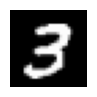

In [ ]:
mnist = TinyMNIST()
concat_l = mnist.tls[0]+mnist.tls[0]
show_at(concat_l, 0)

### Concatenating `Datasets`s

In [ ]:
#| export 
@patch
def __add__(self: Datasets, other: Datasets):
    assert len(self.tls) == len(other.tls)
    return Datasets(tls=[t1 + t2 for t1, t2 in zip(self.tls, other.tls)])

In [ ]:
ds1 = Datasets(list('abc'), ['f1({})'.format, 'f2({})'.format], splits=[[0, 1], [2]])
ds2 = Datasets(list('bcd'), ['g1({})'.format, 'g2({})'.format], splits=[[0], [1, 2]])

test_eq(ds1 + ds2, L(('f1(a)', 'f2(a)'), ('f1(b)', 'f2(b)'), ('f1(c)', 'f2(c)'),
                     ('g1(b)', 'g2(b)'), ('g1(c)', 'g2(c)'), ('g1(d)', 'g2(d)')))


Also concatenates each split separtely:

In [ ]:
test_eq((ds1+ds2).train, ds1.train + ds2.train)
test_eq((ds1+ds2).valid, ds1.valid + ds2.valid)

### Subtracting Sub`Datasets`

In [ ]:
#| export
@patch
def __sub__(self: Datasets, other: Datasets):
    assert self.tfms == other.tfms
    assert set(other.items).issubset(self.items)
    return self.sub_dsets([i for i, o in enumerate(self.items) if o not in set(other.items)])

In [ ]:
test_eq(ds-sub_ds, L(('f(a)', 'g(a)'), ('f(c)', 'g(c)')))
test_eq((ds-sub_ds).train, L([('f(a)', 'g(a)')]))
test_eq((ds-sub_ds).valid, L([('f(c)', 'g(c)')]))

## Targets

In [ ]:
#| export
@patch(as_prop=True)
def i2t(self: Datasets):
    assert self.n_inp == len(self.tls) - 1
    return self.tls[-1]

In [ ]:
ds = Datasets(list('abcd'), ['f({})'.format, 'g({})'.format, 'h({})'.format])
test_eq(ds.i2t, L('h(a)', 'h(b)', 'h(c)', 'h(d)'))

In [ ]:
#| export
@patch(as_prop=True)
def by_target(self: Datasets) -> Dict[int, Datasets]:
    if not hasattr(self, '_by_target'):
        targets = [int(t) for t in progress_bar(self.i2t, comment='Class map: scanning targets')]
        class_map = groupby(enumerate(targets), key=1, val=0)
        self._by_target = {self.vocab[c]: self.sub_dsets(indices)
                           for c, indices in progress_bar(class_map.items(), comment='Class map: partitioning')}
    return self._by_target


In [ ]:
ds = Datasets(range(10), [noop, [lambda o: ['Even', 'Odd'][o%2], Categorize()]])
test_eq(ds.by_target.keys(), ['Even', 'Odd'])
test_eq(ds.by_target['Even'], L((i, ds.vocab.o2i['Even']) for i in [0, 2, 4, 6, 8]))
test_eq(ds.by_target['Odd'],  L((i, ds.vocab.o2i['Odd'])  for i in [1, 3, 5, 7, 9]))

Class map: scanning targets:   0%|          | 0/10 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#| export
import matplotlib.pyplot as plt

@patch()
def plot_class_distribution(self: Datasets):
    for split in self.subsets:
        plt.bar(self.vocab, [len(split.by_target[c]) for c in self.vocab])

Class map: scanning targets:   0%|          | 0/60000 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/10 [00:00<?, ?it/s]

Class map: scanning targets:   0%|          | 0/10000 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/10 [00:00<?, ?it/s]

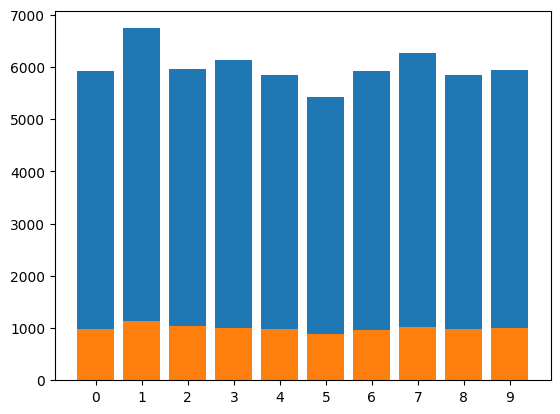

In [ ]:
MNIST().plot_class_distribution()

## Loading

Common default parameters for dataloaders:

In [ ]:
#| export
class ListToTuple(Transform):
    """Transforms lists to tuples, useful for fixing a bug in pytorch (pin_memory turns inner tuples into lists)"""
    def encodes(self, o:list):
        return tuple(o)


In [ ]:
#| exports
dl_defaults = {'pin_memory': default_device() != torch.device('cpu'), 'device': default_device(),
               'after_item': [ToTensor], 'after_batch': [ListToTuple, IntToFloatTensor]}

Convenience methods for creating loaders with `dl_defaults`

In [ ]:
#| export
def _dl_args(kwargs):
    args = deepcopy(dl_defaults)
    for event in ['after_item', 'after_batch']:
        if event in kwargs:
            tfms = kwargs[event]
            args[event] += tfms if isinstance(tfms, Sequence) else [tfms]
    return args


@patch
def dls(self: Datasets, **kwargs) -> DataLoaders:
    """Calls `Datasets.dataloaders` with defaults from `dl_defaults`"""
    return self.dataloaders(**_dl_args(kwargs))


@patch
def dl(self: Datasets, **kwargs) -> DataLoader:
    """Creates a `DataLoader` (ignoring splits) with defaults from `dl_defaults`"""
    return self._dl_type(self, **_dl_args(kwargs))

For small enough datasets, we might want to load all of it to memory:

In [ ]:
#| export
@patch
def load(self: Datasets, **kwargs):
    return first(self.dl(bs=len(self), **kwargs))

In [ ]:
mnist = TinyMNIST()
x, y = mnist.random_sub_dsets(10).load()
test_eq(x.shape, [10, 3, 28, 28])
test_eq(y.shape, [10])

## Misc

In [ ]:
#| export
@patch(as_prop=True)
def subsets(self: Datasets) -> TfmdLists:
    """Lazy list of a `Datasets`'s subsets"""
    return TfmdLists(range(self.n_subsets), self.subset)

In [ ]:
ds = Datasets(list('abcd'), ['f({})'.format, 'g({})'.format], splits=[[0, 2], [1, 3]])
test_eq(ds.subsets, L(ds.train, ds.valid))

In [ ]:
#| export
@patch
def resplit(self: Datasets,
            splits: Union[Callable, List[List[int]]]  # a splitter function or a list of splits
            ):
    """Sets the splits of a `Datasets`"""
    if isinstance(splits, Callable):
        splits = splits(self)
    for t in self.tls:
        t.splits = splits

In [ ]:
ds = Datasets(list('abcd'), ['f({})'.format, 'g({})'.format], splits=[[0, 2], [1, 3]])
ds.resplit(EndSplitter(.75))

test_eq(ds.splits, [[0], [1, 2, 3]])

### Datasets.repr

In [ ]:
#| export
@patch()
def __repr__(self: Datasets):
    return '['+'\n'.join(repr(s) for s in self.subsets)+']' if self.split_idx is None else coll_repr(self)

`Datasets.repr` shows all splits:

In [ ]:
ds = Datasets(list('abcd'), ['f({})'.format, 'g({})'.format], splits=[[0, 2], [1, 3]])
for split in ds.subsets:
    assert repr(split) in repr(ds)

## Usage Examples

In [ ]:
from fastai_datasets.all import *

In [ ]:
mnist = MNIST()

Show dataset structure:

In [ ]:
mnist

[(#60000) [(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0))...]
(#10000) [(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=28x28, TensorCategory(0)),(PILImage mode=RGB size=2

Let's sample a random subset:

In [ ]:
mnist = mnist.random_sub_dsets(1000)

Show its class distribution:

Class map: scanning targets:   0%|          | 0/865 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/10 [00:00<?, ?it/s]

Class map: scanning targets:   0%|          | 0/135 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/10 [00:00<?, ?it/s]

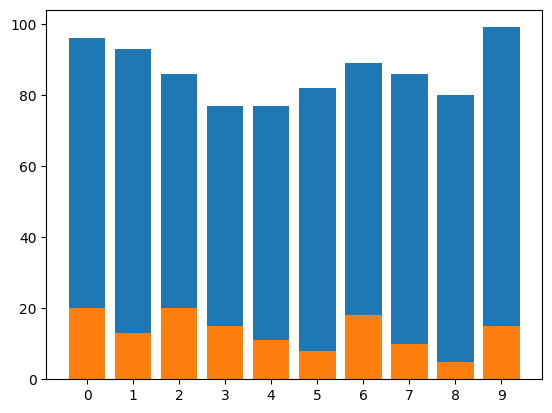

In [ ]:
mnist.plot_class_distribution()

Use only the even digits:

Class map: scanning targets:   0%|          | 0/1000 [00:00<?, ?it/s]

Class map: partitioning:   0%|          | 0/10 [00:00<?, ?it/s]

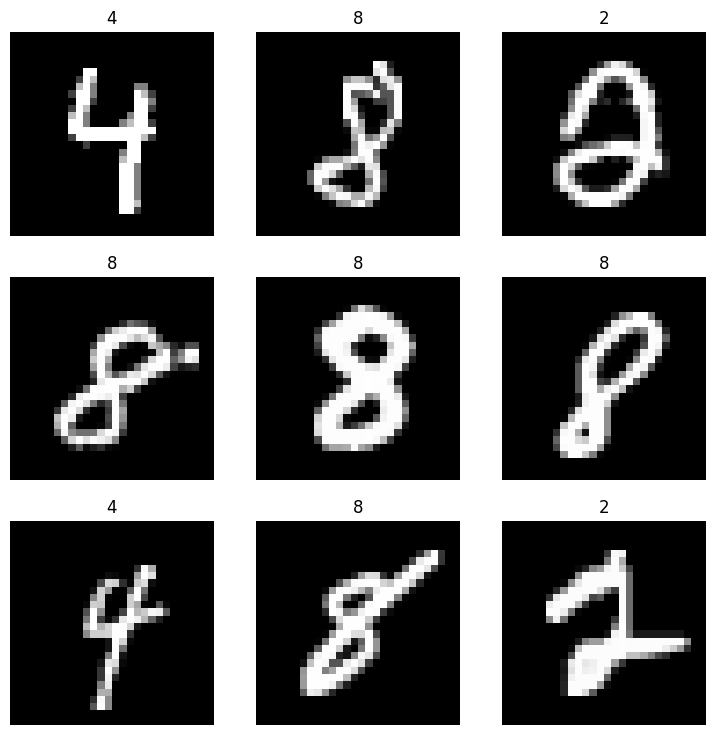

In [ ]:
evens = mnist.by_target['0'] + mnist.by_target['2'] + mnist.by_target['4'] + mnist.by_target['6'] + mnist.by_target['8']
evens.dls().show_batch()

Drop specific classes:

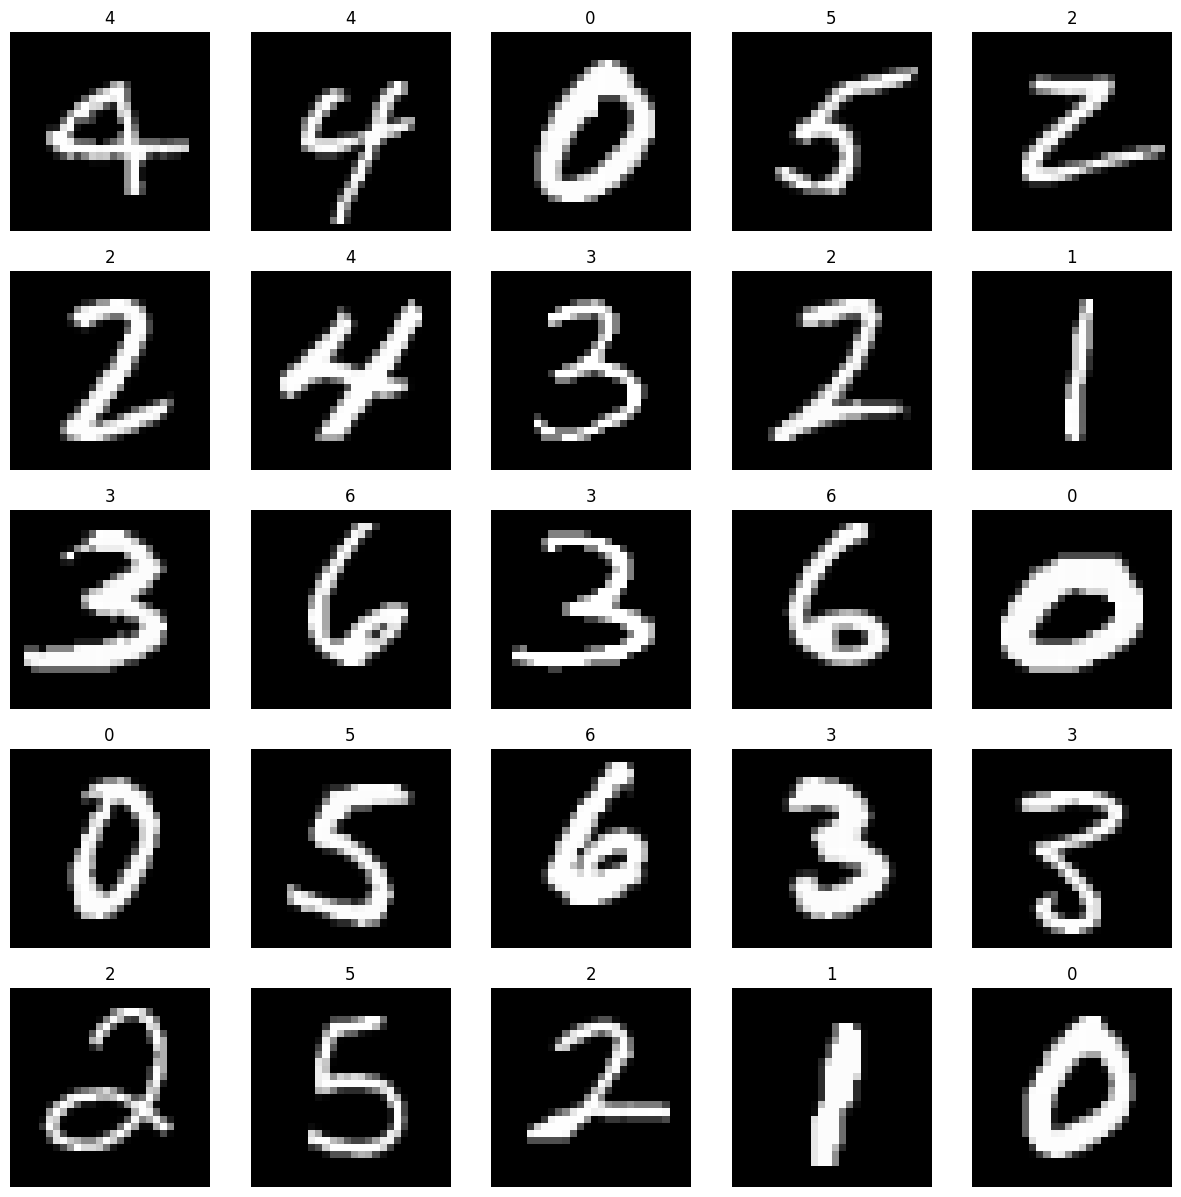

In [ ]:
less_than_7 = mnist - mnist.by_target['9'] - mnist.by_target['8'] - mnist.by_target['7']
less_than_7.dl().show_batch(max_n=25)

Estimate the mean sample from a specific class:

<Axes: >

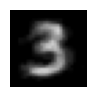

In [ ]:
threes_sample = mnist.by_target['3'].random_sub_dsets(20)
show_image(threes_sample.load()[0].mean(0))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()